In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error


df = pd.read_csv('dailyboardingtotals.csv')
df['service_date'] = pd.to_datetime(df['service_date'])
df = df.sort_values('service_date')

df['prev_day_rides'] = df['total_rides'].shift(1)
df['prev_week_rides'] = df['total_rides'].shift(7)
df['one_year_ago_rides'] = df['total_rides'].shift(364)


#data split
df2023 = df[df['service_date'].dt.year == 2023].dropna()
df2024 = df[df['service_date'].dt.year == 2024].dropna()

In [126]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

def makeModel(trainingVarIn, trainVarOut, feature_cols=None, trainModel=LinearRegression):
    model = make_pipeline(trainModel())
    model.fit(trainingVarIn, trainVarOut)
    # Print feature weights if possible
    estimator_name = [name for name in model.named_steps if hasattr(model.named_steps[name], 'coef_')]
    est = model.named_steps[estimator_name[0]]
    # If feature_cols is None, print generic names
    if feature_cols is None:
        feature_cols = [f"x{i}" for i in range(len(est.coef_))]
    print(f"{estimator_name[0].capitalize()} Weights:")
    for name, coef in zip(feature_cols, est.coef_):
        print(f"  {name}: {coef}")
    return model

def makeModelGD(trainingVarIn, trainVarOut, feature_cols=None):
    model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=2000, tol=1e-10, random_state=42))
    model.fit(trainingVarIn, trainVarOut)
    reg = model.named_steps['sgdregressor']
    if feature_cols is None:
        feature_cols = [f"x{i}" for i in range(len(reg.coef_))]
    print("SGDRegressor Weights:")
    for name, coef in zip(feature_cols, reg.coef_):
        print(f"  {name}: {coef}")
    return model

def predictModel(model, testVars):
    testVarOut = model.predict(testVars)
    return testVarOut

def predictError(y_test, testVarOut):
    mse = mean_squared_error(y_test, testVarOut)
    mae = np.mean(np.abs(y_test - testVarOut))
    print(f"2024 Mean Squared Error: {mse:e}")
    print(f"2024 Mean Absolute Error: {mae:e}")

def graphData(df2024, y_test, y_pred):
    plt.figure(figsize=(10,6))
    plt.plot(df2024['service_date'], y_test, label='Actual 2024', color='black')
    plt.plot(df2024['service_date'], y_pred, label='Predicted 2024', color='red')
    plt.xlabel('Date')
    plt.ylabel('Total Rides')
    plt.title('Actual vs Predicted Total Rides')
    plt.legend()
    plt.show()

    # Plot predicted vs actual for January 2024
    plt.figure(figsize=(10,6))
    plt.plot(df2024[df2024['service_date'].dt.month == 1]['service_date'],
         y_test[df2024['service_date'].dt.month == 1],
         label='Actual Jan 2024', color='black')
    plt.plot(df2024[df2024['service_date'].dt.month == 1]['service_date'],
         y_pred[df2024['service_date'].dt.month == 1],
         label='Predicted Jan 2024', color='red')

    # # Add actual data from last week of December 2023
    # last_week_dec = (df2023['service_date'] >= pd.Timestamp('2023-12-25')) & (df2023['service_date'] <= pd.Timestamp('2023-12-31'))
    # plt.plot(df2023['service_date'][last_week_dec],
    #      y_train[last_week_dec],
    #      label='Actual Last Week Dec 2023', color='blue', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Total Rides')
    plt.title('Actual vs Predicted Total Rides')
    plt.legend()    
def totalRun(X_train, y_train, X_test, y_test, feature_cols=None):
    model = makeModel(X_train, y_train, feature_cols=feature_cols)
    y_pred = predictModel(model, X_test)
    predictError(y_test, y_pred)
    graphData(df2024, y_test, y_pred)

def totalRunGD(X_train, y_train, X_test, y_test, feature_cols=None):
    model = makeModelGD(X_train, y_train, feature_cols=feature_cols)
    y_pred = predictModel(model, X_test)
    predictError(y_test, y_pred)
    graphData(df2024, y_test, y_pred)

def totalRunComp(X_train, y_train, X_test, y_test, feature_cols=None):
    print("Running standard linear regression model...")
    model = makeModel(X_train, y_train, feature_cols=feature_cols)
    y_pred = predictModel(model, X_test)
    predictError(y_test, y_pred)
    graphData(df2024, y_test, y_pred)
    print("Running gradient descent model...")
    modelGD = makeModelGD(X_train, y_train, feature_cols=feature_cols)
    y_predGD = predictModel(modelGD, X_test)
    predictError(y_test, y_predGD)
    graphData(df2024, y_test, y_predGD)
    graphData(df2024, y_test, y_predGD)

Running standard linear regression model...
Linearregression Weights:
  x0: 0.07122287683541527
  x1: 0.18979355103188575
  x2: 0.7667555136262918
2024 Mean Squared Error: 9.212053e+09
2024 Mean Absolute Error: 5.872242e+04


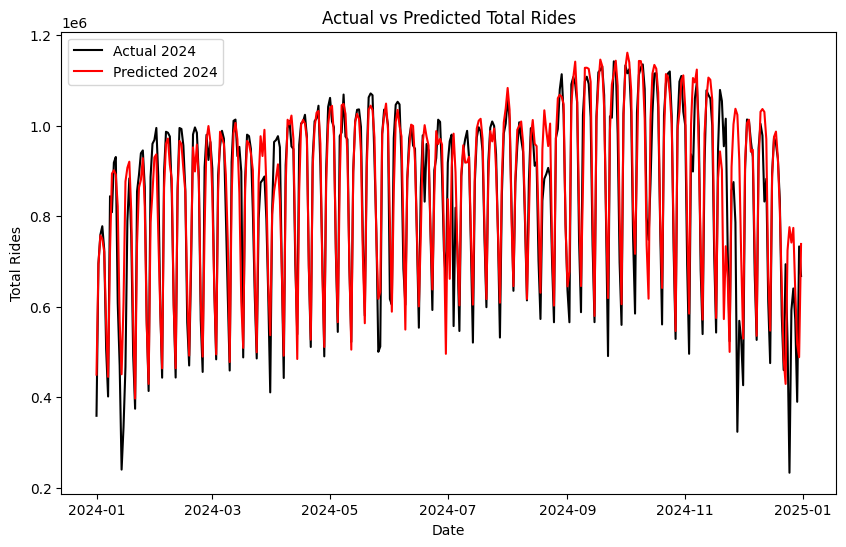

Running gradient descent model...
SGDRegressor Weights:
  x0: 520578020528425.2
  x1: 927117320054209.1
  x2: 303966863382734.6
2024 Mean Squared Error: 2.208318e+42
2024 Mean Absolute Error: 1.454983e+21


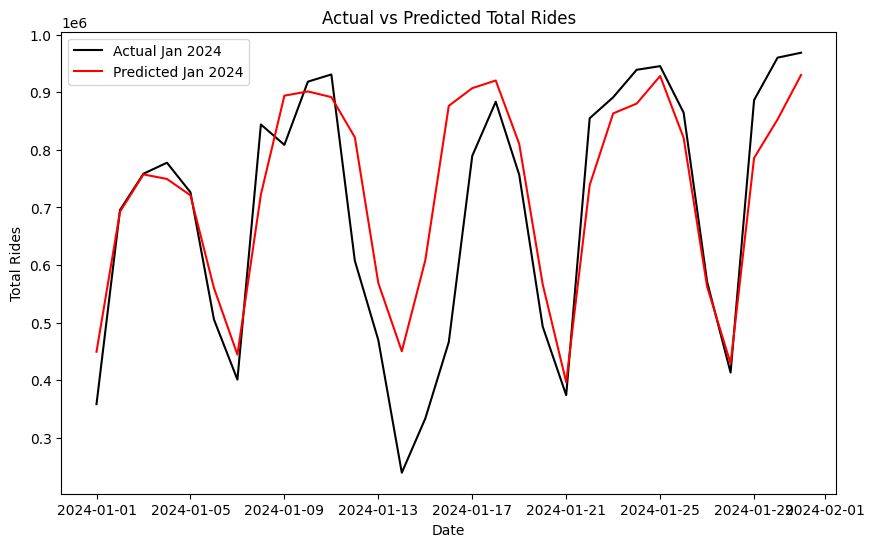

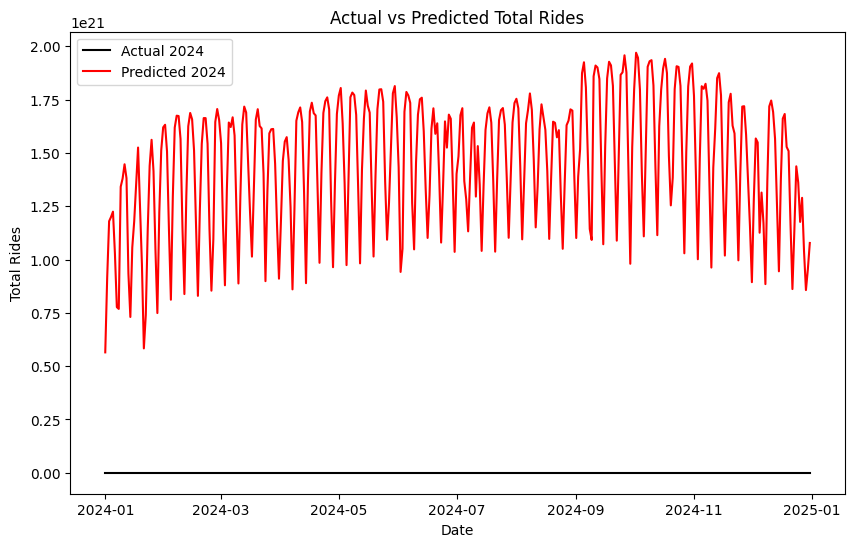

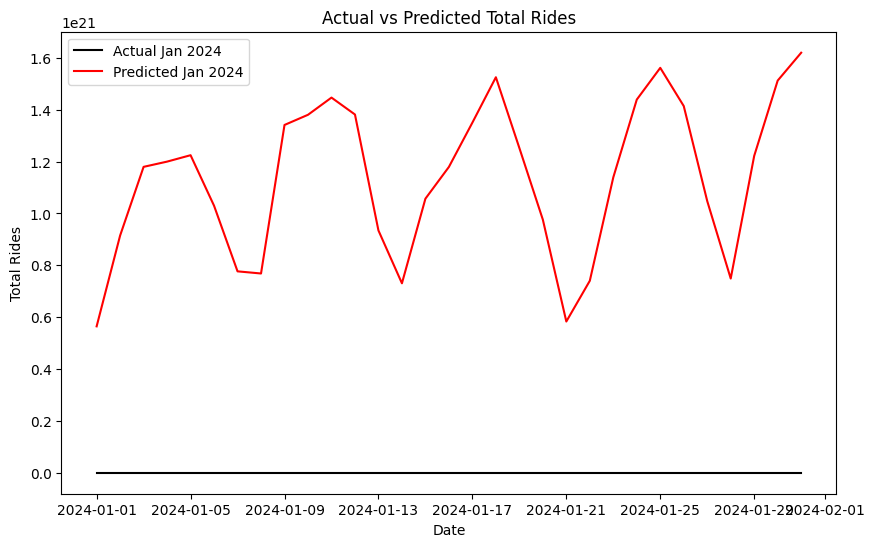

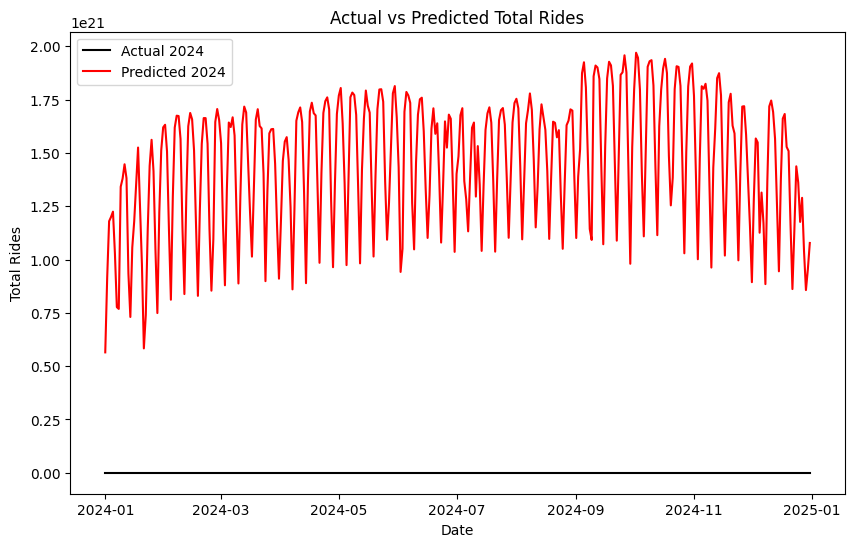

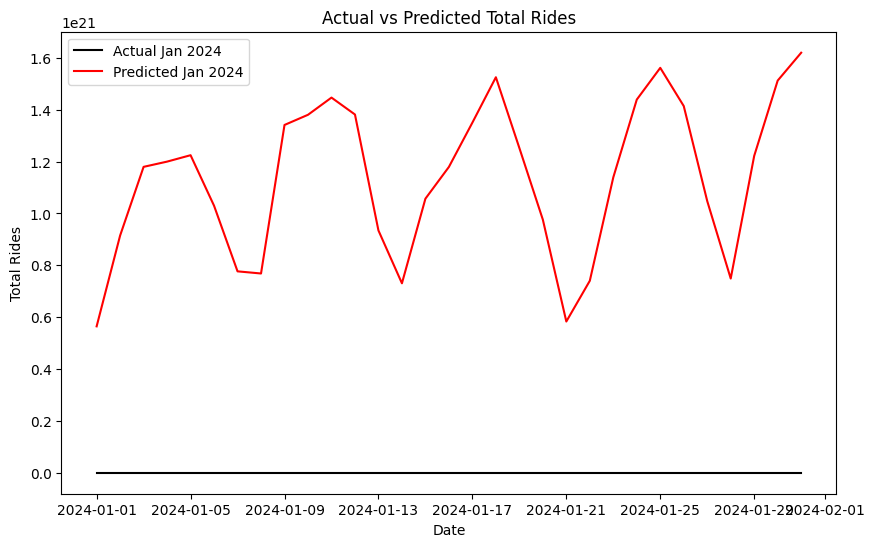

In [125]:
#PREV DAY< WEEK< AND YEAR
X_train2023 = df2023[['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']].values
y_train2023 = df2023['total_rides'].values
X_test2024 = df2024[['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']].values
y_test2024 = df2024['total_rides'].values

#totalRun(X_train2023, y_train2023, X_test2024, y_test2024)
totalRunComp(X_train2023, y_train2023, X_test2024, y_test2024)


Running standard linear regression model...
Linearregression Weights:
  x0: 0.07122287683541527
  x1: 0.18979355103188575
  x2: 0.7667555136262918
2024 Mean Squared Error: 9.212053e+09
2024 Mean Absolute Error: 5.872242e+04


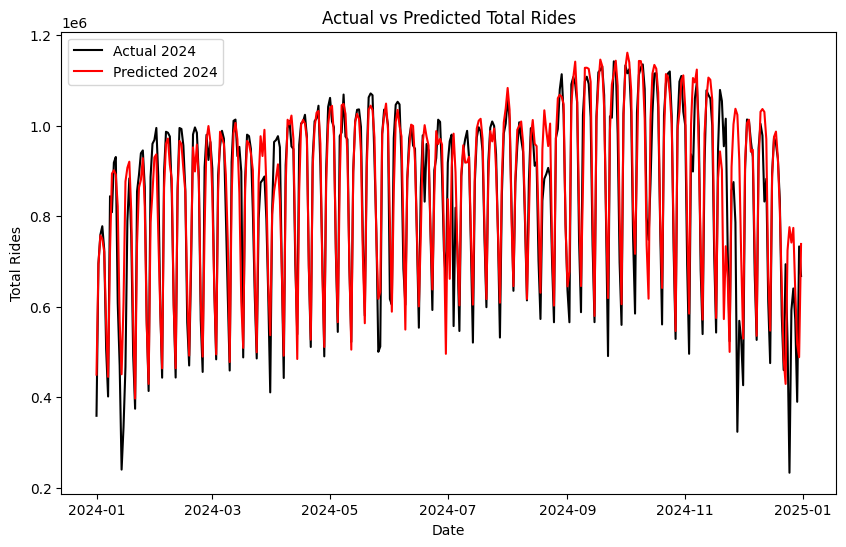

Running gradient descent model...
SGDRegressor Weights:
  x0: 13672.605009232853
  x1: 37959.41755799703
  x2: 138373.5558358964
2024 Mean Squared Error: 9.178483e+09
2024 Mean Absolute Error: 5.865455e+04


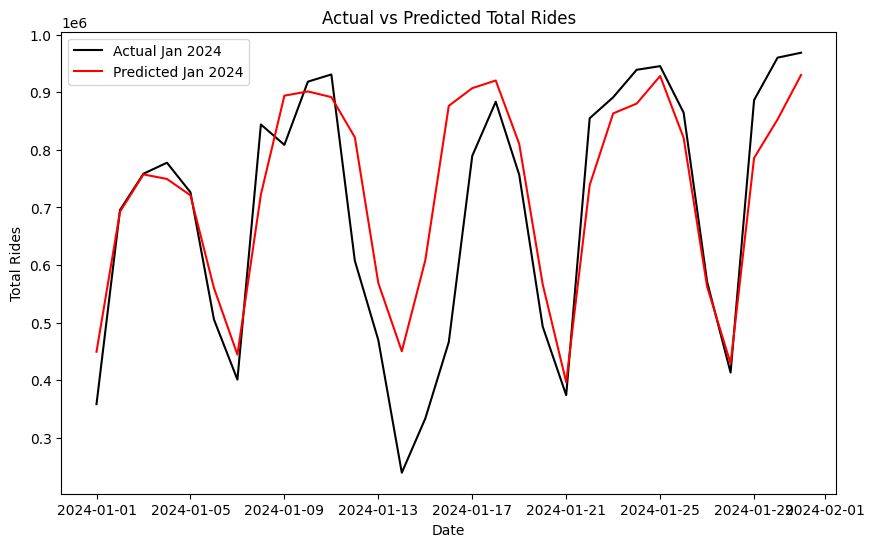

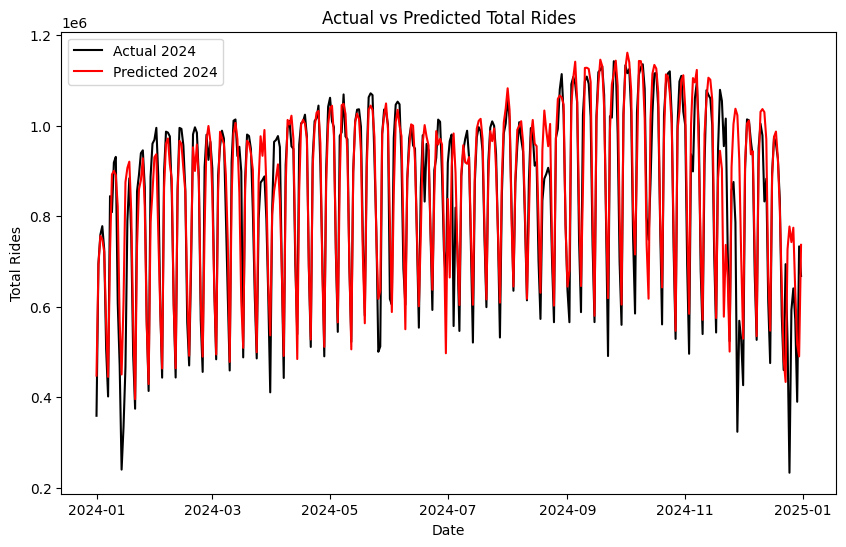

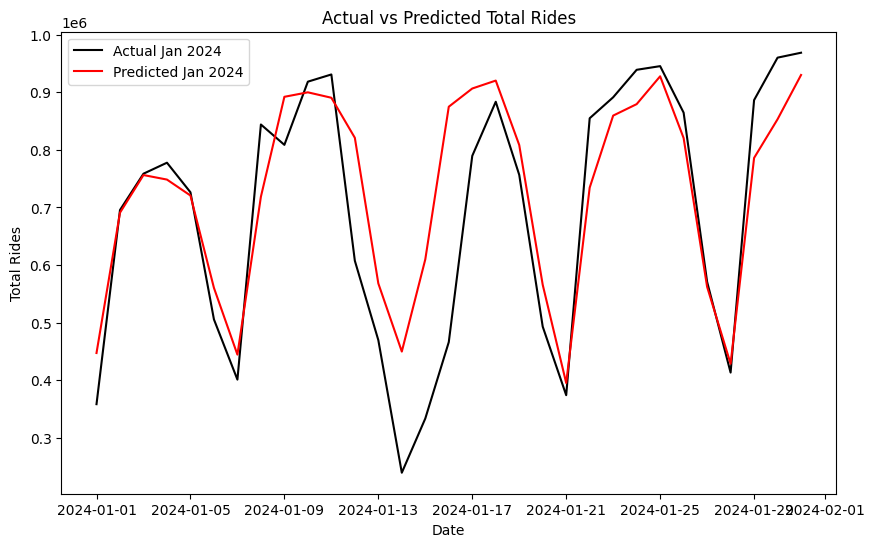

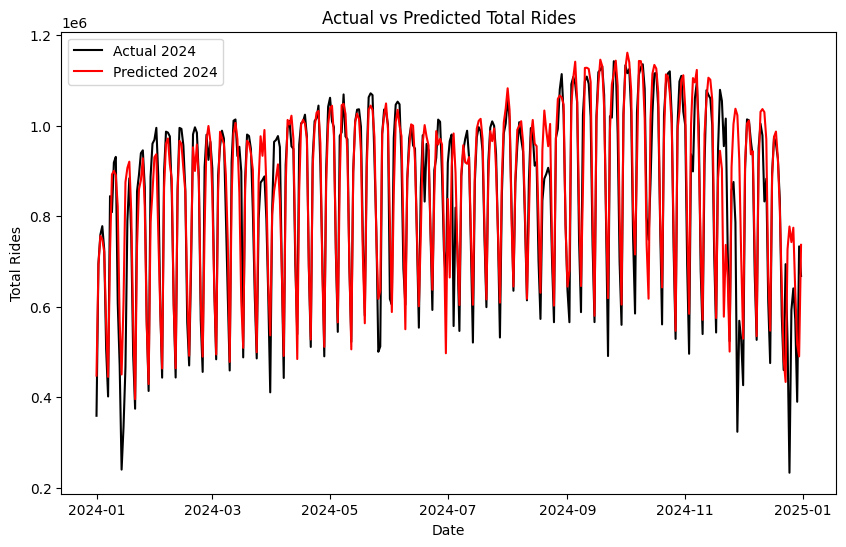

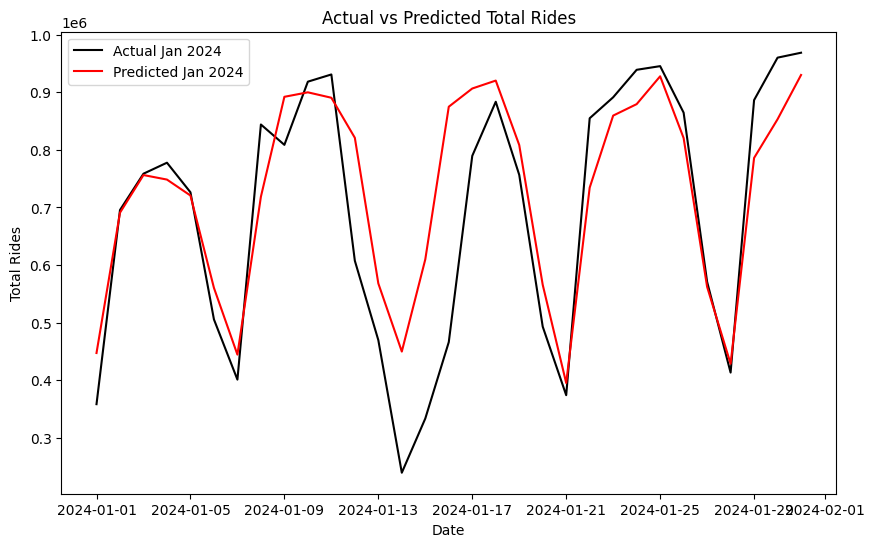

In [119]:
#PREV DAY< WEEK< AND YEAR
X_train2023 = df2023[['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']].values
y_train2023 = df2023['total_rides'].values
X_test2024 = df2024[['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']].values
y_test2024 = df2024['total_rides'].values

totalRunComp(X_train2023, y_train2023, X_test2024, y_test2024)


In [ ]:
weather = pd.read_csv('chicagoweather.csv', index_col='datetime', parse_dates=True)
df = pd.read_csv('dailyboardingtotals.csv')
df['service_date'] = pd.to_datetime(df['service_date'])

df = df.set_index('service_date')
df = df.sort_index()


df['prev_day_rides'] = df['total_rides'].shift(1)
df['prev_week_rides'] = df['total_rides'].shift(7)
df['one_year_ago_rides'] = df['total_rides'].shift(364)
numeric_df = df[['total_rides', 'prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']]
daily = numeric_df.resample('d').mean()

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(daily.index.min(), daily.index.max())
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

# Weather features
weather['TMIN_C'] = (weather['tempmin'] - 32) * 5.0/9.0
weather['TMAX_C'] = (weather['tempmax'] - 32) * 5.0/9.0
weather['Temp (C)'] = 0.5 * (weather['TMIN_C'] + weather['TMAX_C'])
weather['PRCP_mm'] = weather['precip'] * 25.4
weather['dry day'] = (weather['PRCP_mm'] == 0).astype(int)

daily = daily.join(weather[['PRCP_mm', 'Temp (C)', 'dry day']])
daily['annual'] = (daily.index - daily.index[0]).days / 365.

daily.dropna(axis=0, how='any', inplace=True)

allCol = ['total_rides', 'prev_day_rides', 'prev_week_rides', 'one_year_ago_rides',
                'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'PRCP_mm', 'dry day', 'Temp (C)', 'annual']

rideData = ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']
rideWeatherData = rideData + ['PRCP_mm', 'dry day', 'Temp (C)', 'annual']




/var/folders/6f/s14ngf096w3ctv98g3j3n_gr0000gn/T/ipykernel_71712/3287224091.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['holiday'].fillna(0, inplace=True)


['total_rides', 'prev_day_rides', 'prev_week_rides', 'one_year_ago_rides', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'PRCP_mm', 'dry day', 'Temp (C)', 'annual']
Running standard linear regression model...
Linearregression Weights:
  x0: 0.9999999999999968
  x1: 1.8812790751110485e-17
  x2: 5.19087237764356e-15
  x3: -3.137440874538865e-15
  x4: -8.244596268970141e-12
  x5: 1.5533583235153308e-12
  x6: 2.0507520954363055e-12
  x7: -6.492894905991808e-13
  x8: -8.491032005949549e-13
  x9: 1.4316301779144445e-13
  x10: 5.9957155154896546e-12
  x11: 1.1496814733054498e-11
  x12: -2.428963104233655e-13
  x13: -4.672090501581303e-12
  x14: -2.335763704909615e-14
  x15: 4.839978742405145e-12
2024 Mean Squared Error: 4.849518e-19
2024 Mean Absolute Error: 4.424418e-10


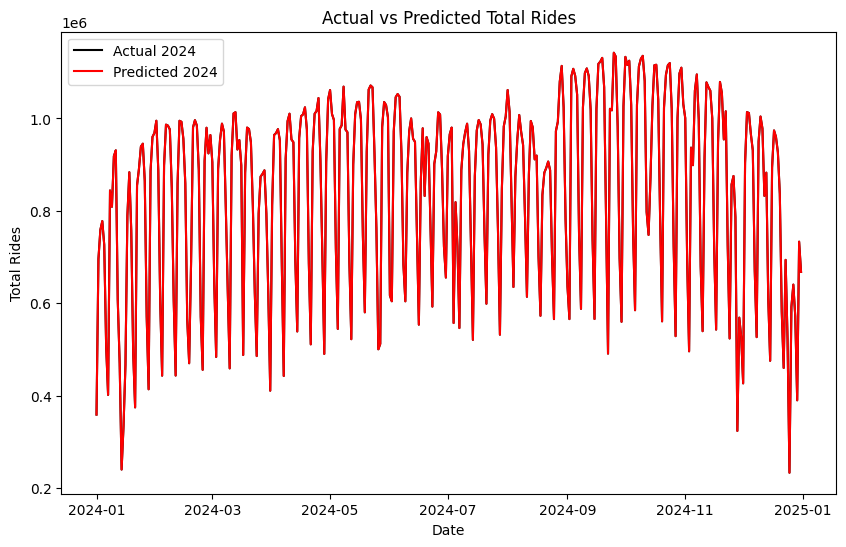

Running gradient descent model...
SGDRegressor Weights:
  x0: 189711.01066319828
  x1: 153.87410636635968
  x2: 12.739350511828333
  x3: 143.15916984263626
  x4: 113.29558144535417
  x5: 55.94706904765542
  x6: 30.538305038343854
  x7: 24.426583818864554
  x8: -6.794018442163206
  x9: -102.94744036349155
  x10: -113.56262458283615
  x11: -91.76607828456466
  x12: -30.791360927025007
  x13: 19.508551294600238
  x14: 14.358431263223698
  x15: 12.986016767262985
2024 Mean Squared Error: 1.920149e+04
2024 Mean Absolute Error: 9.057159e+01


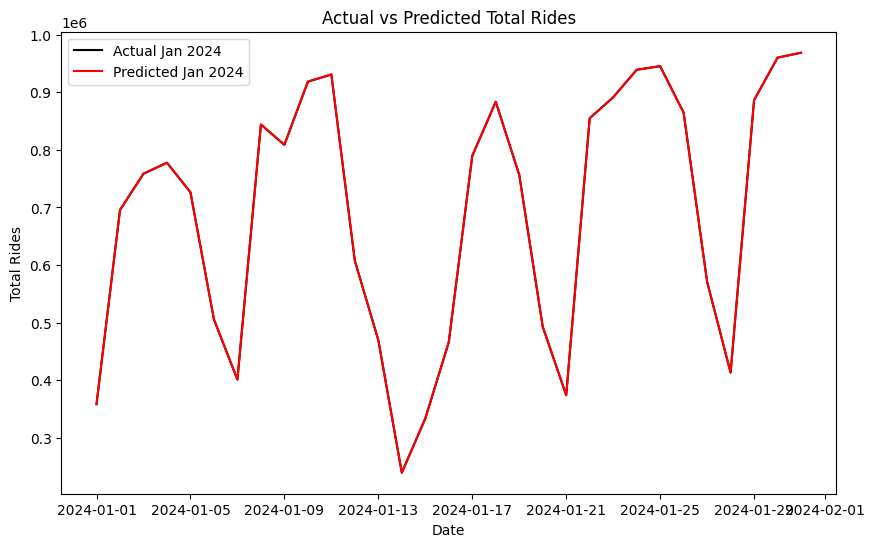

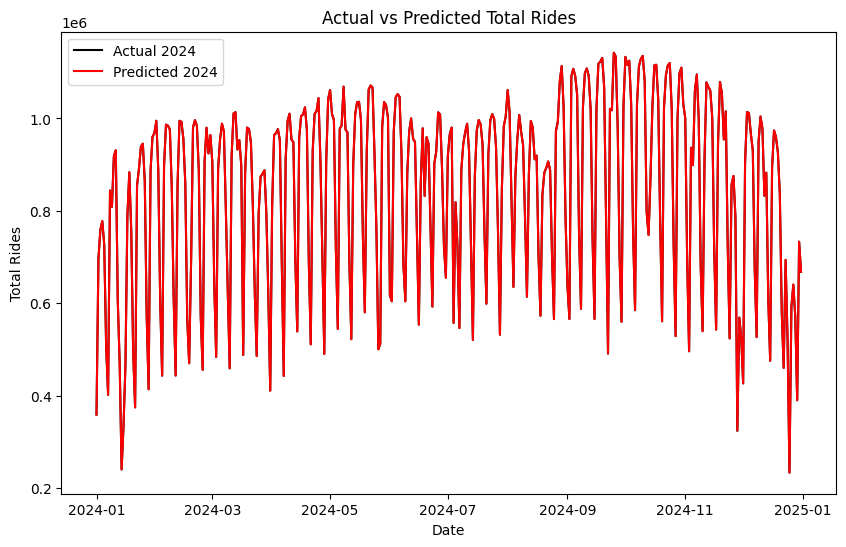

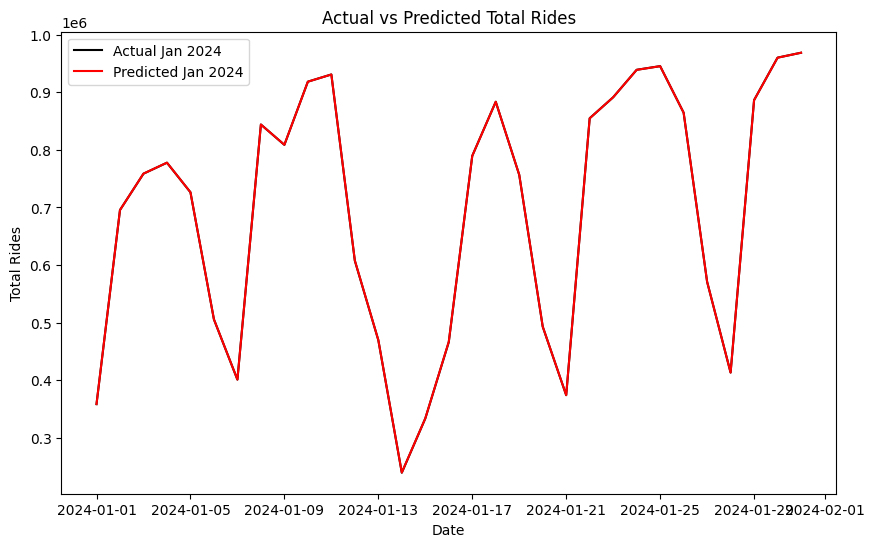

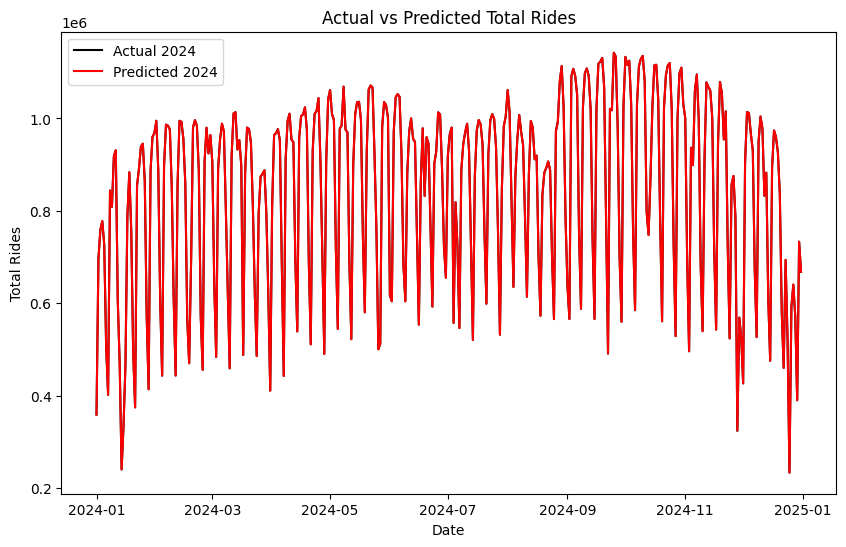

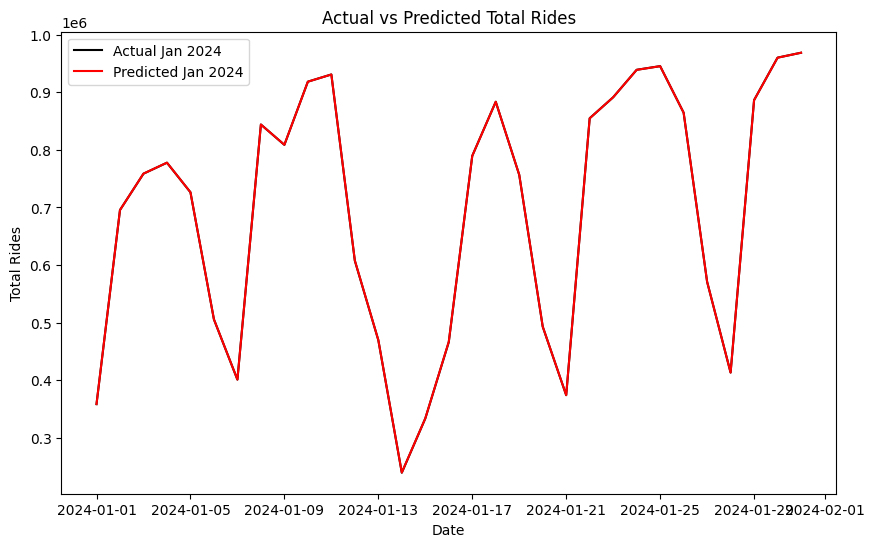

In [123]:
daily2023 = daily[daily.index.year == 2023]
daily2024 = daily[daily.index.year == 2024]
X_train2023 = daily2023[allCol].values
y_train2023 = daily2023['total_rides'].values
X_test2024 = daily2024[allCol].values
y_test2024 = daily2024['total_rides'].values
print(allCol)

totalRunComp(X_train2023, y_train2023, X_test2024, y_test2024)
#totalRunGD(X_train2023, y_train2023, X_test2024, y_test2024)


#daily

Running model with features: ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides']
Running standard linear regression model...
2024 Mean Squared Error: 9.212053e+09
2024 Mean Absolute Error: 5.872242e+04


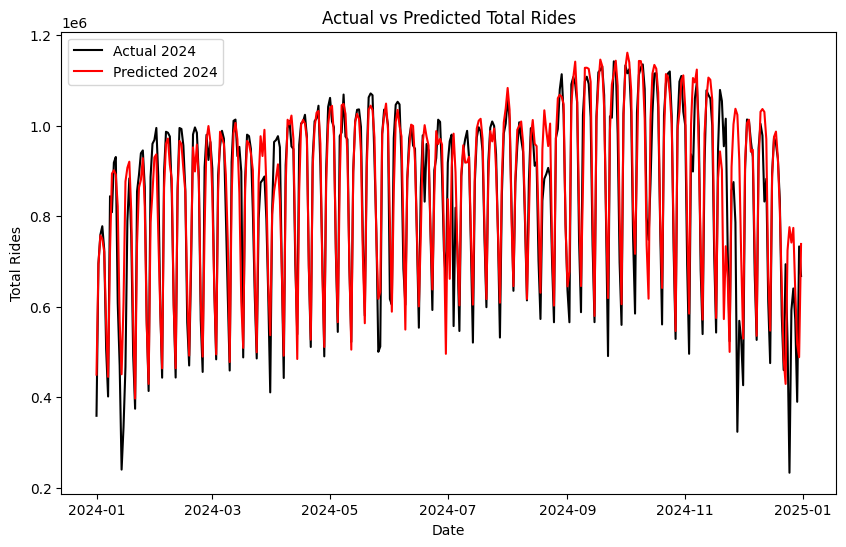

Running gradient descent model...
2024 Mean Squared Error: 9.178483e+09
2024 Mean Absolute Error: 5.865455e+04


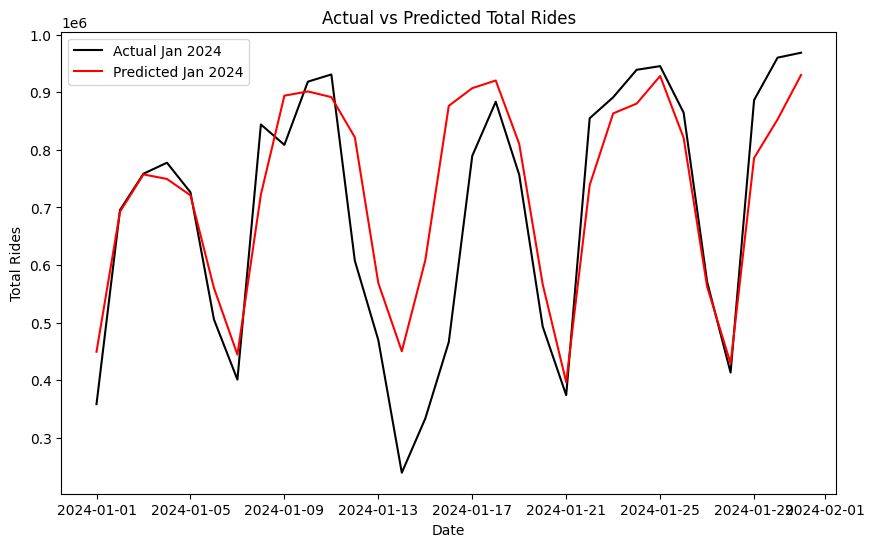

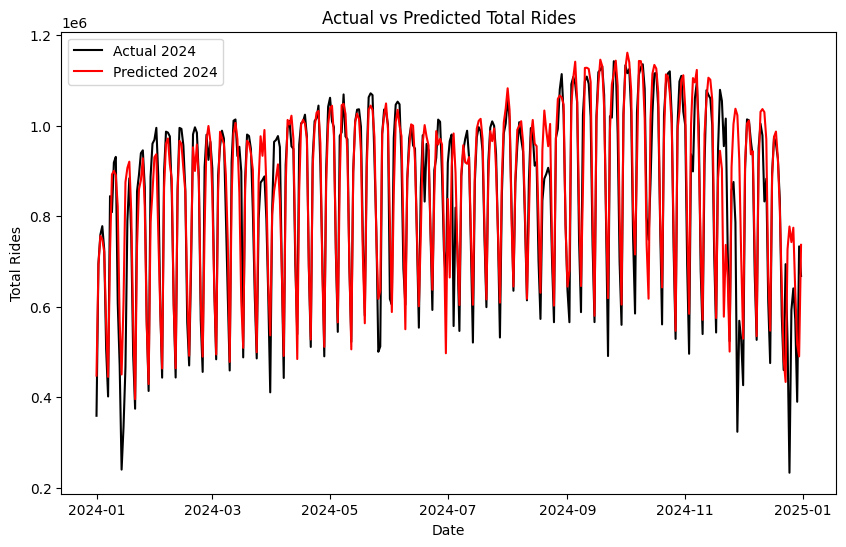


Running model with features: ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'PRCP_mm', 'dry day', 'Temp (C)']
Running standard linear regression model...
2024 Mean Squared Error: 3.873076e+09
2024 Mean Absolute Error: 4.161192e+04


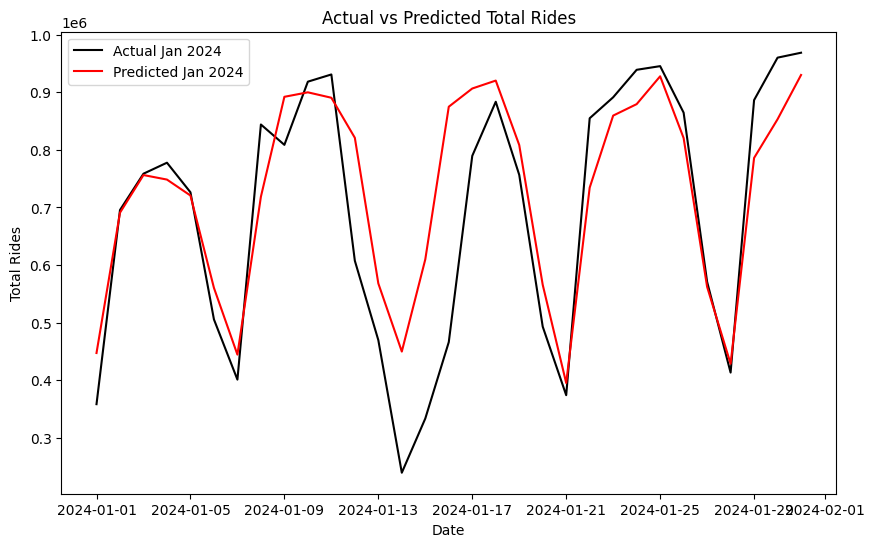

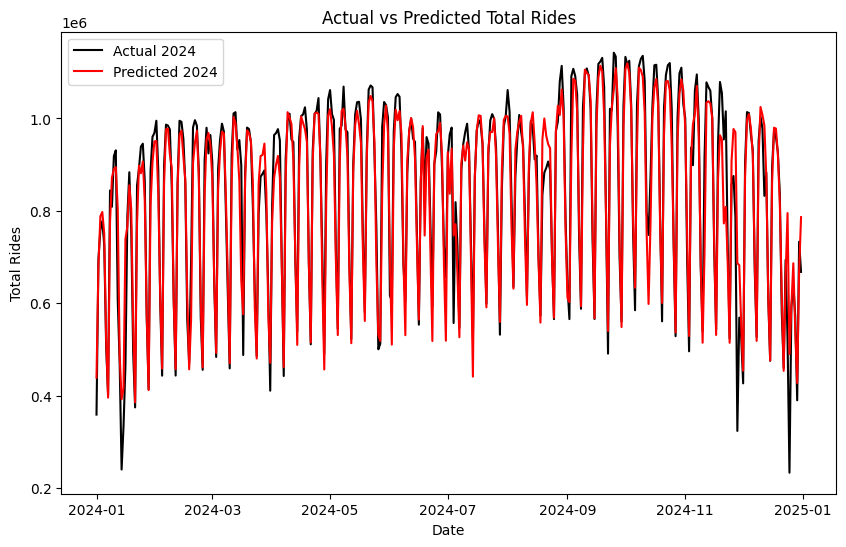

Running gradient descent model...
2024 Mean Squared Error: 4.004002e+09
2024 Mean Absolute Error: 4.199207e+04


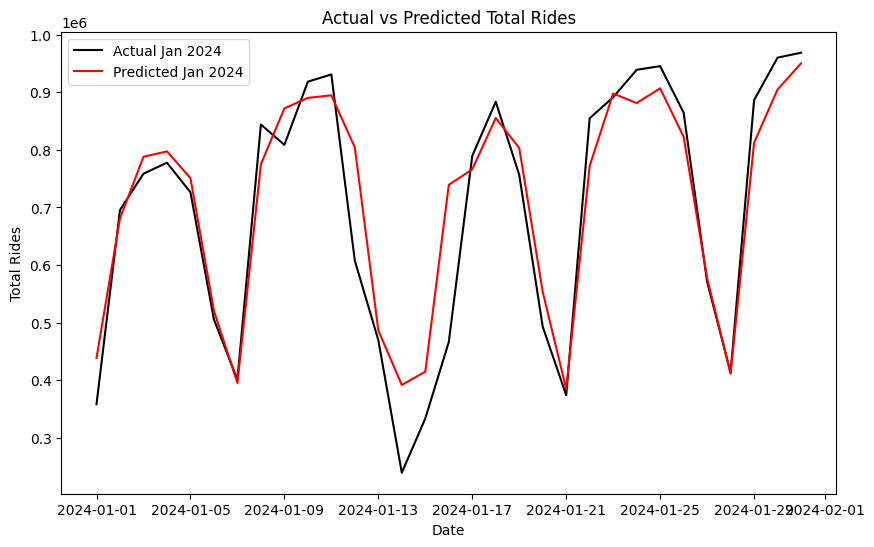

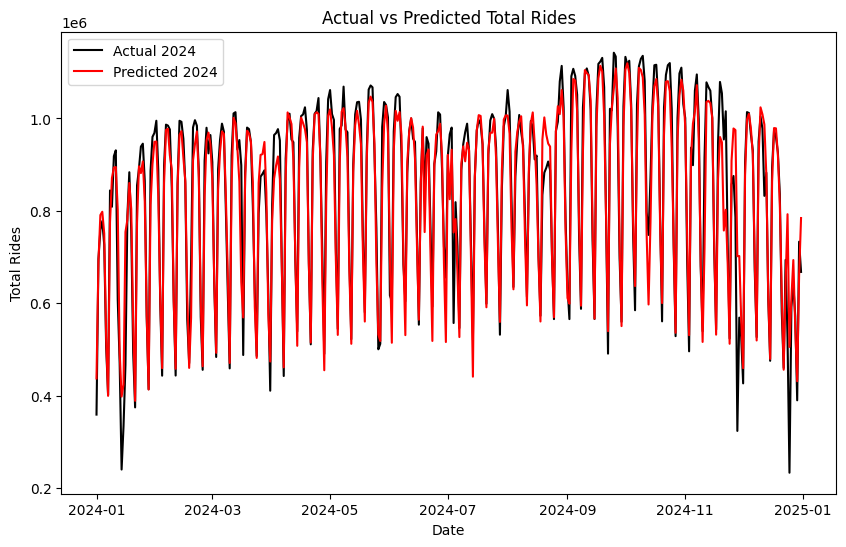


Running model with features: ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'PRCP_mm', 'dry day', 'Temp (C)', 'annual']
Running standard linear regression model...
2024 Mean Squared Error: 3.960862e+09
2024 Mean Absolute Error: 4.111383e+04


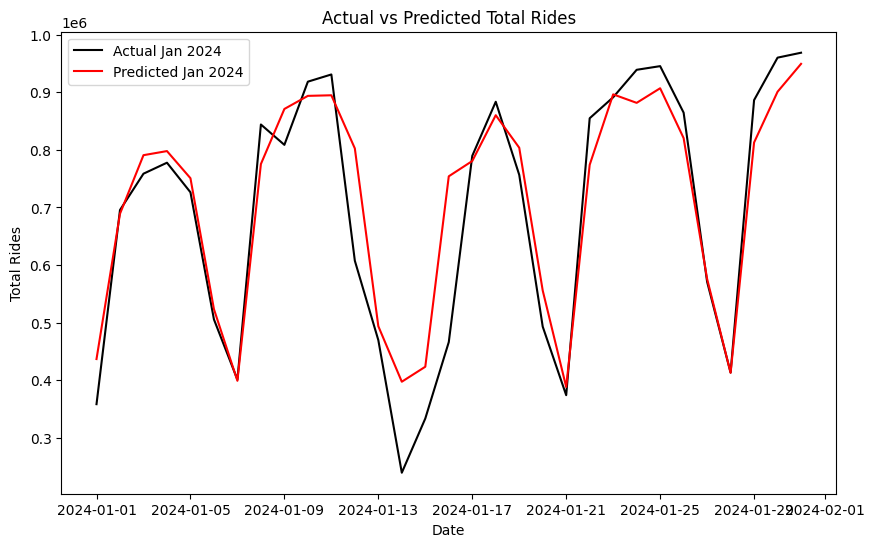

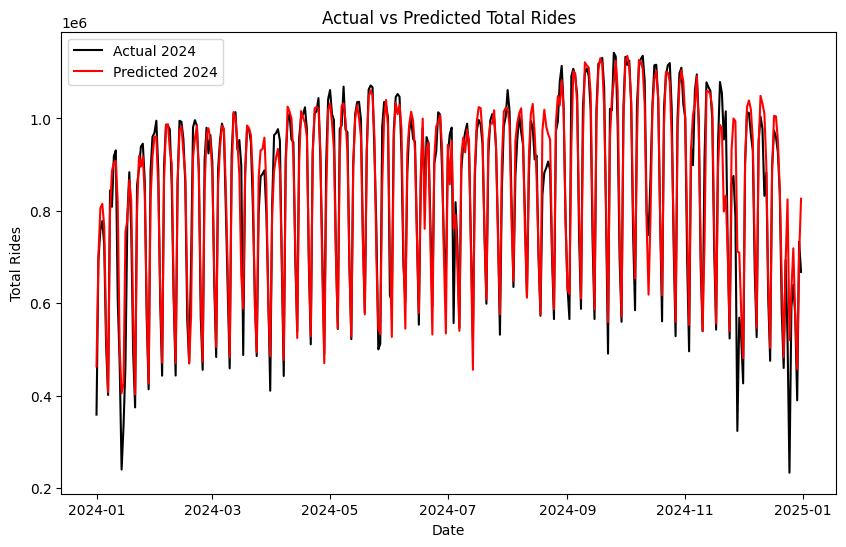

Running gradient descent model...
2024 Mean Squared Error: 4.053092e+09
2024 Mean Absolute Error: 4.129764e+04


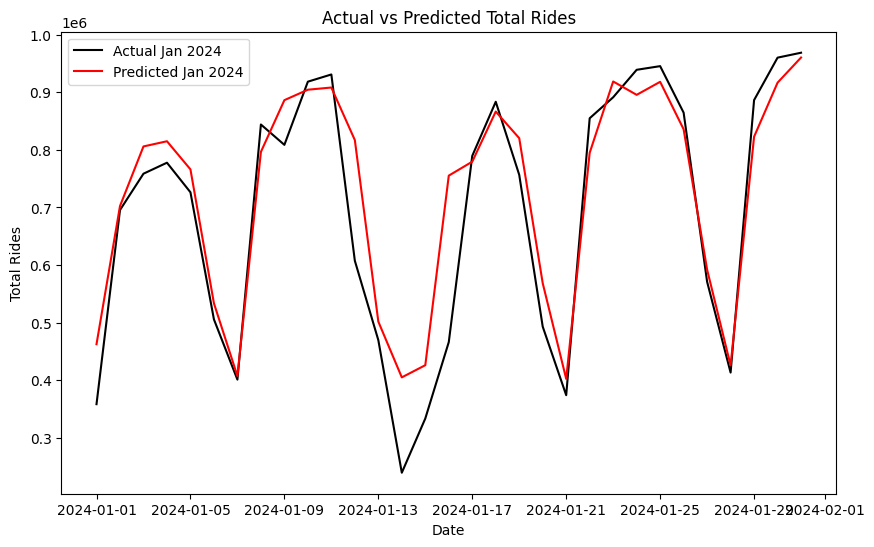

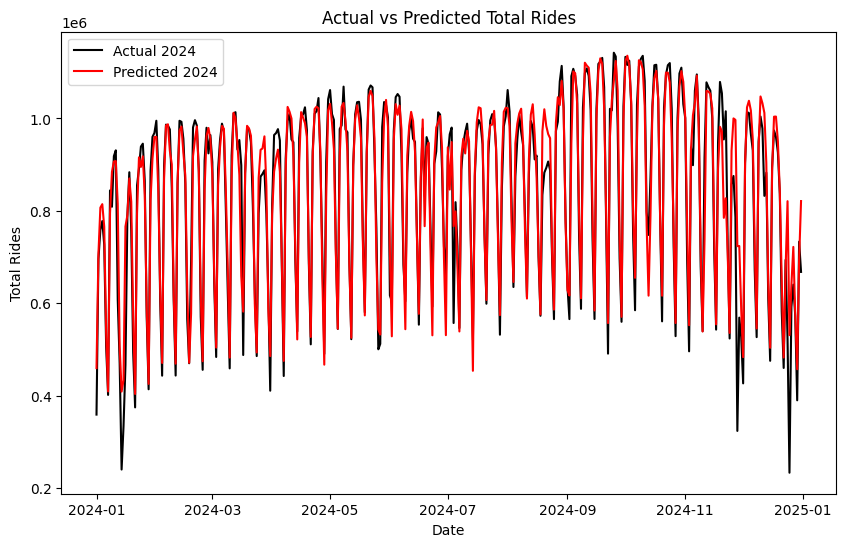

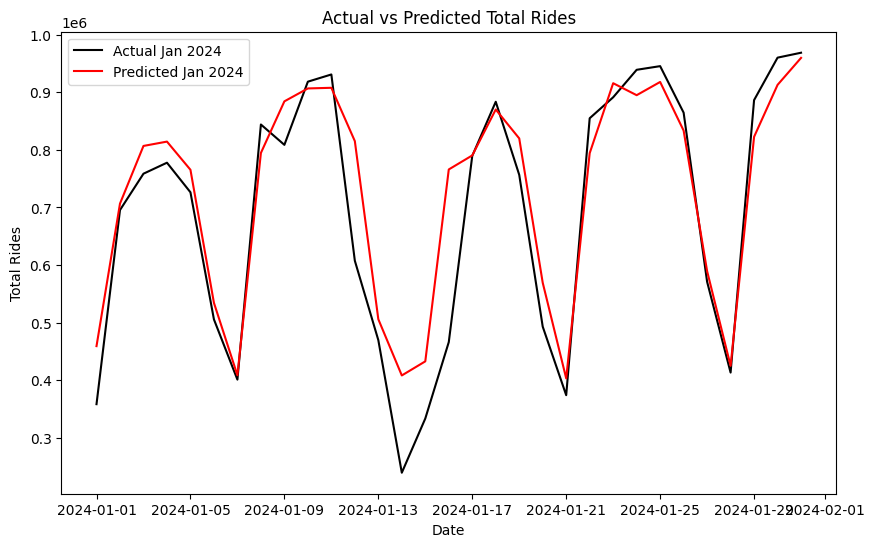

In [102]:
daily2023 = daily[daily.index.year == 2023]
daily2024 = daily[daily.index.year == 2024]
X_train2023 = daily2023['prev_day_rides'].values.reshape(-1, 1)
y_train2023 = daily2023['total_rides'].values
X_test2024 = daily2024['prev_day_rides'].values.reshape(-1, 1)
y_test2024 = daily2024['total_rides'].values

x_cols = [
    ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides'],
    ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides', 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday',
 'PRCP_mm',
 'dry day',
 'Temp (C)'],
 ['prev_day_rides', 'prev_week_rides', 'one_year_ago_rides','Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday',
 'PRCP_mm',
 'dry day',
 'Temp (C)',
 'annual'],

]
for x_col in x_cols:
    X_train2023 = daily2023[x_col].values
    y_train2023 = daily2023['total_rides'].values
    X_test2024 = daily2024[x_col].values
    y_test2024 = daily2024['total_rides'].values
    print(f"Running model with features: {x_col}")
    totalRunComp(X_train2023, y_train2023, X_test2024, y_test2024)
    print()
    #totalRunGD(X_train2023, y_train2023, X_test2024, y_test2024)


#daily

In [94]:
allCol

['total_rides',
 'prev_day_rides',
 'prev_week_rides',
 'one_year_ago_rides',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday',
 'PRCP_mm',
 'dry day',
 'Temp (C)',
 'annual']

2024 Mean Squared Error: 3.213208e+10
2024 Mean Absolute Error: 1.585598e+05


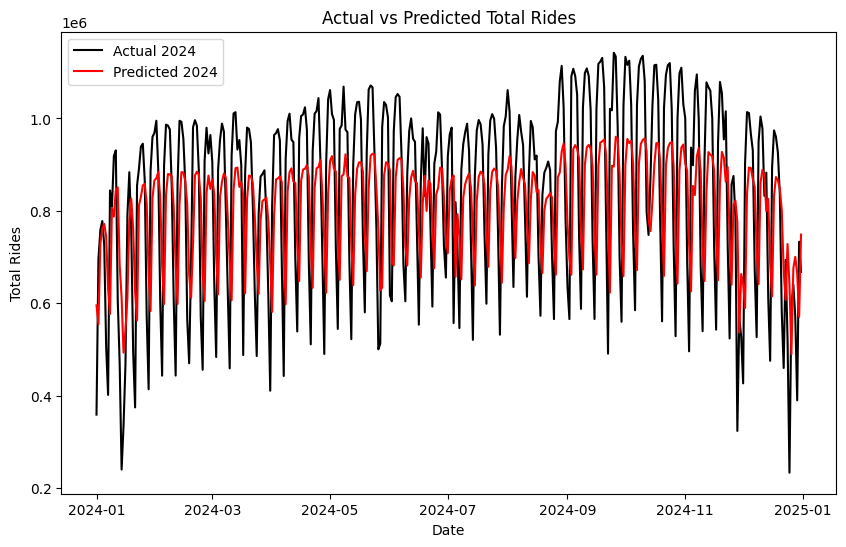

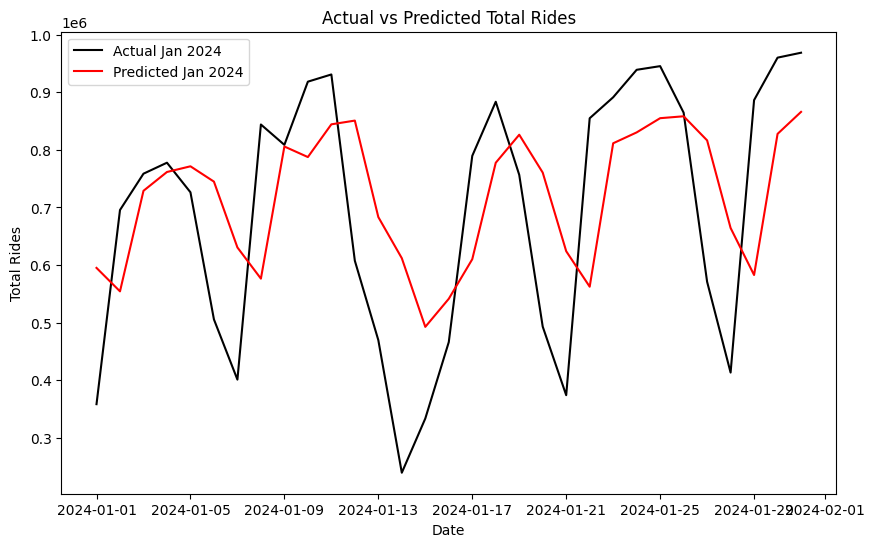

In [58]:
daily2023 = daily[daily.index.year == 2023]
daily2024 = daily[daily.index.year == 2024]
X_train2023 = daily2023['prev_day_rides'].values.reshape(-1, 1)
y_train2023 = daily2023['total_rides'].values
X_test2024 = daily2024['prev_day_rides'].values.reshape(-1, 1)
y_test2024 = daily2024['total_rides'].values

totalRun(X_train2023, y_train2023, X_test2024, y_test2024)

#daily

2024 Mean Squared Error: 4.611007e-20
2024 Mean Absolute Error: 1.938665e-10


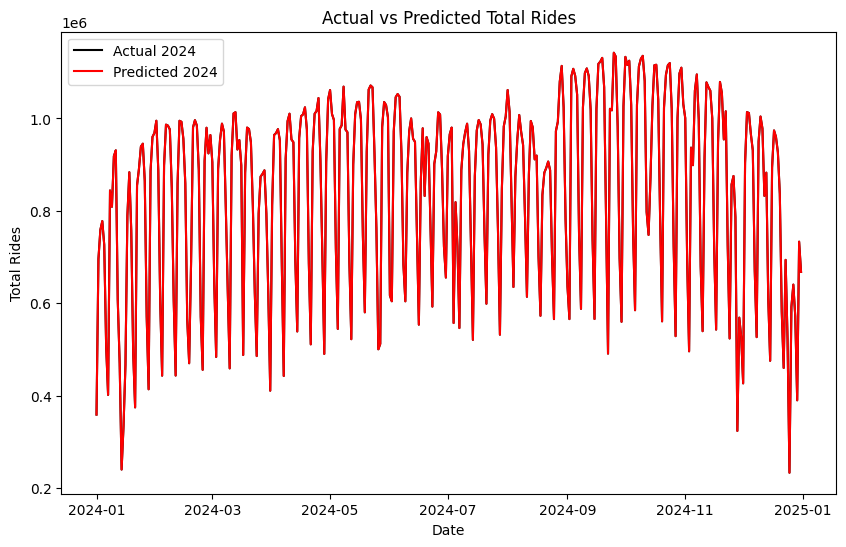

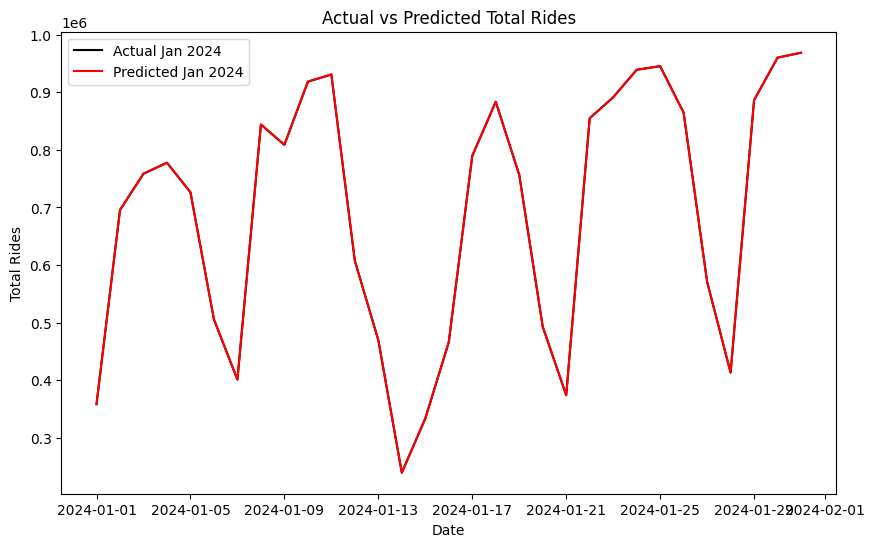

In [49]:
daily2023 = daily[daily.index.year == 2023]
daily2024 = daily[daily.index.year == 2024]
X_train2023 = daily2023[rideData].values
y_train2023 = daily2023['total_rides'].values
X_test2024 = daily2024[rideData].values
y_test2024 = daily2024['total_rides'].values

totalRun(X_train2023, y_train2023, X_test2024, y_test2024)

#daily

2024 Mean Squared Error: 3.833171e-19
2024 Mean Absolute Error: 3.632413e-10


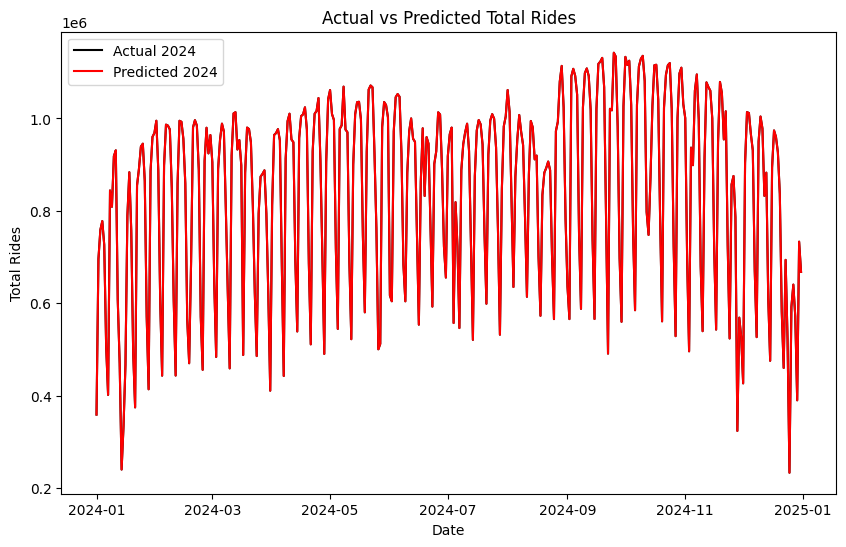

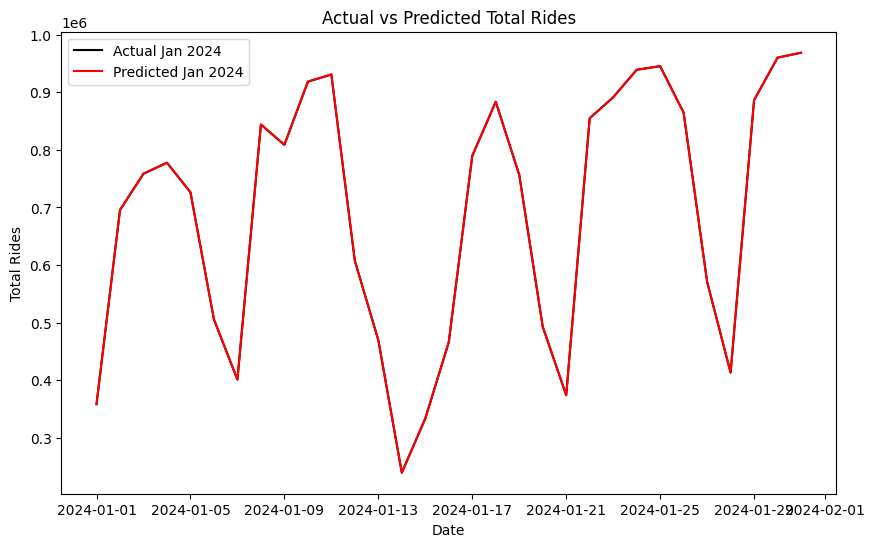

In [50]:
daily2023 = daily[daily.index.year == 2023]
daily2024 = daily[daily.index.year == 2024]
X_train2023 = daily2023[rideWeatherData].values
y_train2023 = daily2023['total_rides'].values
X_test2024 = daily2024[rideWeatherData].values
y_test2024 = daily2024['total_rides'].values

totalRun(X_train2023, y_train2023, X_test2024, y_test2024)

#daily

In [23]:
weather = pd.read_csv('chicagoweather.csv', index_col='datetime', parse_dates=True)
# Weather features
weather['TMIN_C'] = (weather['tempmin'] - 32) * 5.0/9.0
weather['TMAX_C'] = (weather['tempmax'] - 32) * 5.0/9.0
weather['Temp (C)'] = 0.5 * (weather['TMIN_C'] + weather['TMAX_C'])
weather['PRCP_mm'] = weather['precip'] * 25.4
weather['dry day'] = (weather['PRCP_mm'] == 0).astype(int)

weather


,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,moonphase,conditions,description,icon,stations,TMIN_C,TMAX_C,Temp (C),PRCP_mm,dry day
datetime,,,,,,,,,,,,,,,,,,,,,
2022-08-26,"Chicago, IL, United States",78.1,67.4,72.5,78.1,67.4,72.5,61.9,70.2,0.000,...,0.98,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,AP878,KORD,KMDW,72530094846,F1983,...",19.666667,25.611111,22.638889,0.0000,1
2022-08-27,"Chicago, IL, United States",82.4,62.4,72.7,83.1,62.4,72.9,59.9,65.9,0.000,...,0.00,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,"72534014819,AP878,KORD,KMDW,72530094846,F1983,...",16.888889,28.000000,22.444444,0.0000,1
2022-08-28,"Chicago, IL, United States",89.9,70.6,79.9,94.5,70.6,82.2,66.3,63.9,0.078,...,0.05,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72534014819,AP878,KORD,KMDW,72530094846,F1983,...",21.444444,32.166667,26.805556,1.9812,0
2022-08-29,"Chicago, IL, United States",85.4,71.9,78.0,92.4,71.9,79.3,68.2,72.2,0.328,...,0.08,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"72534014819,AP878,KORD,KMDW,72530094846,F1983,...",22.166667,29.666667,25.916667,8.3312,0
2022-08-30,"Chicago, IL, United States",80.4,68.2,74.8,80.2,68.2,74.8,56.5,54.3,0.088,...,0.12,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"72534014819,AP878,KORD,KMDW,72530094846,F1983,...",20.111111,26.888889,23.500000,2.2352,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-19,"Chicago, IL, United States",16.6,2.7,8.6,1.4,-15.6,-7.7,-9.0,44.1,0.000,...,0.69,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665...",-16.277778,-8.555556,-12.416667,0.0000,1
2025-01-20,"Chicago, IL, United States",11.9,-0.7,5.1,-4.2,-18.4,-11.2,-10.9,47.6,0.000,...,0.72,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665...",-18.166667,-11.166667,-14.666667,0.0000,1
2025-01-21,"Chicago, IL, United States",1.8,-6.6,-1.4,-14.1,-26.4,-19.7,-16.7,47.8,0.000,...,0.75,Clear,Clear conditions throughout the day.,clear-day,"72534014819,KORD,KMDW,72530094846,F1983,KPWK,7...",-21.444444,-16.777778,-19.111111,0.0000,1
